In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('./1-4/')
from lr_utils import load_dataset

In [2]:
# import dataset
X_train, Y_train, X_test, Y_test, classes = load_dataset()
X_train = X_train.reshape((X_train.shape[0], -1)).T / 255
X_test = X_test.reshape((X_test.shape[0], -1)).T / 255
print(f'X_train.shape = {X_train.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'Y_train.shape = {Y_train.shape}')
print(f'Y_test.shape = {Y_test.shape}')

X_train.shape = (12288, 209)
X_test.shape = (12288, 50)
Y_train.shape = (1, 209)
Y_test.shape = (1, 50)


In [3]:
#  I have already implement model 'Layer' and 'Model' in practice 1-3

def tanh(x):
    s = np.tanh(x)
    return s

def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

def ReLU(x):
    s = np.maximum(x, 0)
    return s


class Layer(object):
    '''
    implement general Layer which can fowardpropagate and 
    backpropagate with parameters like W,b and so on as it's
    attributes.

    initial parameters of a Layer instance：

    n_input: int, number of input features
    n_layer: int, number of layer units
    activate: function, chose from [tanh, sigmoid, ReLU]
    name: str, default None, optional
    '''
    def __init__(self, n_input, n_layer, activate, name=None):
        self.n = n_layer
        self.name = name
        self.activate = activate
        self.X = None
        self.W = np.random.randn(n_layer, n_input) * 1e-4
        self.b = np.zeros((n_layer, 1))
        self.Z = None
        self.A = None
        self.dA = None
        self.dZ = None
        self.dW = None
        self.db = None
        self.dX = None

    def get_W(self):
        return self.W

    def get_b(self):
        return self.b

    def get_A(self):
        return self.A

    def get_dX(self):
        return self.dX    

    def fwprop(self, X):
        self.X = X
        self.Z = np.dot(self.W, self.X) + self.b
        self.A = self.activate(self.Z)

    def bkprop(self, dA, alpha):
        self.dA = dA
        if self.activate == tanh:
            self.dZ = self.dA * (1 - self.A**2)
        elif self.activate == sigmoid:
            self.dZ = self.dA * self.A * (1 - self.A)
        elif self.activate == ReLU:
            self.dZ = self.dA * (self.A > 0)
        else:
            print('Wrong activate function!')
        self.dX = np.dot(self.W.T, self.dZ)
        self.dW = np.dot(self.dZ, self.X.T)
        self.db = np.mean(self.dZ, axis=1).reshape((self.n, 1))
        self.W -= alpha * self.dW
        self.b -= alpha * self.db



class Model(object):
    '''
    implement general Model which can add layer, fowardpropagate, compute 
    cost, backpropagate, train, predict and score.

    layer list can be found in the attribute Model.layers.
    
    parameters like W,b can be found in attributes of layers in the
    layer list.

    initial parameters of a Model instance：

    X_train: np.ndarray, input of training data
    Y_train: np.ndarray, output of training data
    alpha: float, learning rate, default to be 0.005
    loops: int, number of iteration you want to train, default 2000
    '''
    def __init__(self, X_train, Y_train, alpha=0.005, loops=2000):
        self.X = X_train
        self.Y = Y_train
        self.alpha = alpha
        self.loops = loops
        self.L = 0
        self.layers = []
        self.layers_reverse = []
        self.A = None
        self.J = None
        self.J_list = []

    def add_layer(self, n_input, n_layer, activate, name=None):
        self.L += 1
        new_layer = Layer(n_input, n_layer, activate, name=name)
        self.layers.append(new_layer)
        self.layers_reverse = self.layers.copy()
        self.layers_reverse.reverse()
        return new_layer

    def fwprop(self):
        input_ = self.X
        for layer in self.layers:
            layer.fwprop(input_)
            input_ = layer.get_A()

    def compute_J(self):
        self.A = self.layers[-1].get_A()
        # 防止出现log(0)等于nan的情况, 每次log()内加上极小正数
        self.J = (-self.Y * np.log(self.A + 1e-10) - (1 - self.Y) * np.log(1 - self.A + 1e-10)).mean()

    def bkprop(self):
        # 防止出现x / 0等于nan的情况, 每次 / 分母加上极小正数
        dA = -self.Y / (self.A +10e-10) + (1 - self.Y) / (1 - self.A +10e-10)
        for layer in self.layers_reverse:
            layer.bkprop(dA, alpha=self.alpha)
            dA = layer.get_dX()

    def train(self):
        for i in range(self.loops):
            self.fwprop()
            self.compute_J()
            self.bkprop()
            j = i + 1
            if j%50 == 0:
                self.J_list.append(self.J)
                print(f'loss of iteration No.{j}: {self.J}')

    def predict(self, X_test):
        for layer in self.layers:
            layer.fwprop(X_test)
            X_test = layer.get_A()
        return X_test

    def score(self, X_test, Y_test):
        Y_predict = self.predict(X_test)
        result = (Y_predict > 0.5) == Y_test
        acc = result.mean()
        return acc

    def plot_loss(self):
        plt.plot(self.J_list)
        plt.xlabel('steps per 50')
        plt.ylabel('loss')
        plt.title('loss circle')
        plt.show()


In [13]:
model_2l = Model(X_train, Y_train, alpha=0.0001, loops=5000)
model_2l.add_layer(12288, 7, ReLU, name='hiden layer with 7 units')
model_2l.add_layer(7, 1, sigmoid, name='output layer')
model_2l.train()

loss of iteration No.50: 0.6704410787253591
loss of iteration No.100: 0.6354361390252494
loss of iteration No.150: 0.589330953767144
loss of iteration No.200: 0.5536652684648333
loss of iteration No.250: 0.5266868464099151
loss of iteration No.300: 0.4999901664025018
loss of iteration No.350: 0.46773229779173764
loss of iteration No.400: 0.4528741306569272
loss of iteration No.450: 0.43668849614766375
loss of iteration No.500: 0.4033916319812862
loss of iteration No.550: 0.3382471472198163
loss of iteration No.600: 0.5041876424875942
loss of iteration No.650: 0.36362793306116403
loss of iteration No.700: 0.3938382489334329
loss of iteration No.750: 0.34758228749354436
loss of iteration No.800: 0.2712585409146793
loss of iteration No.850: 0.30347919612736707
loss of iteration No.900: 0.17164510455030763
loss of iteration No.950: 0.1515562696498035
loss of iteration No.1000: 0.17144507385663357
loss of iteration No.1050: 0.12405150333594991
loss of iteration No.1100: 0.29221763061091705


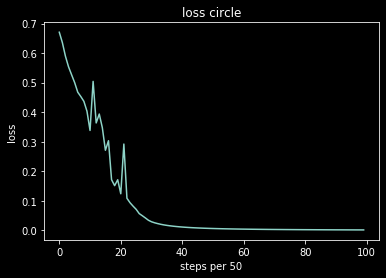

In [14]:
model_2l.plot_loss()

In [16]:
print(model_2l.score(X_test, Y_test))
# not good 

0.68
